In [1]:
import pandas as pd

### Monthly car sales in quebec, 1960 (non-stationary)

In [2]:
car_sales = pd.read_csv('monthly-car-sales-in-quebec-1960.csv')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

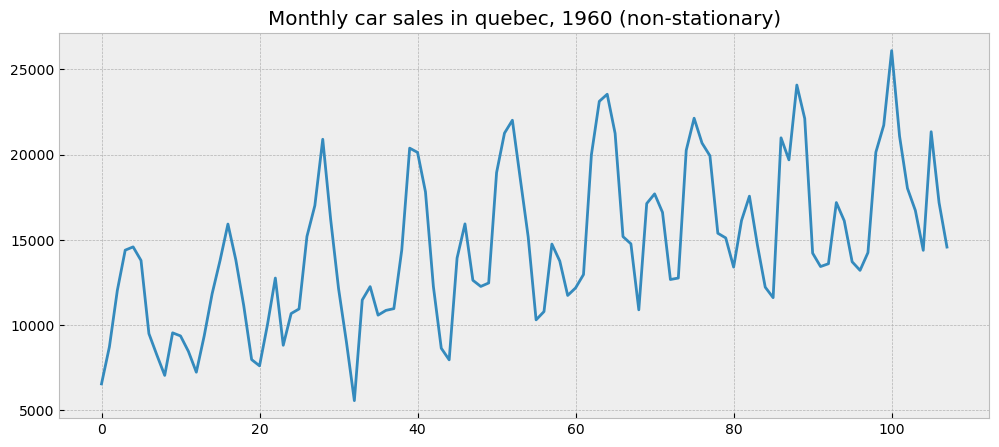

In [4]:
plt.style.use('bmh')
plt.figure(figsize=(12, 5))
plt.plot(car_sales['Count'])
plt.title('Monthly car sales in quebec, 1960 (non-stationary)')
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
result = adfuller(car_sales['Count'])
print('Dickey-Fuller test for "Monthly car sales in quebec, 1960 (non-stationary)":')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for k, v in result[4].items():
    print(f'   {k}: {v}')
print()

Dickey-Fuller test for "Monthly car sales in quebec, 1960 (non-stationary)":
ADF Statistic: -1.2238127661752853
p-value: 0.6632691049832862
Critical Values:
   1%: -3.5011373281819504
   5%: -2.8924800524857854
   10%: -2.5832749307479226



#### Выполним приближение ряда

Временной ряд содержит и тренд, и сезонность, поэтому будем использовать тройное экспоненциальное сглаживание

In [7]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [8]:
series = car_sales['Count']

In [9]:
train, test, val = series[:90], series[90:100], series[100:]

Запишем вспомогательные функции

In [10]:
# def initial_trend(series, season_len):
#     for i in range(season_len): return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [11]:
def initial_trend(series, season_len):
    initial_trend = 0
    for i in range(season_len): initial_trend += float(series[i + season_len] - series[i]) / season_len
    return initial_trend / season_len

In [12]:
# def initial_trend(series, season_len):
#     sum = 0.
#     for i in range(season_len):
#         sum += float(series[i+season_len] - series[i]) / season_len
#     return sum / season_len

In [13]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j: slen*j + slen]) / float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

In [14]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series) + n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [15]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(12, 5))
        plt.plot(ser_to_plot, label='original')
        plt.plot(tema, label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [16]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [17]:
opt = minimize(mse, x0=[0, 0, 0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [18]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 5664656.126464581
        x: [ 1.000e+00  0.000e+00  1.000e+00]
      nit: 1
      jac: [-1.112e+06  1.658e+08 -0.000e+00]
     nfev: 8
     njev: 2
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


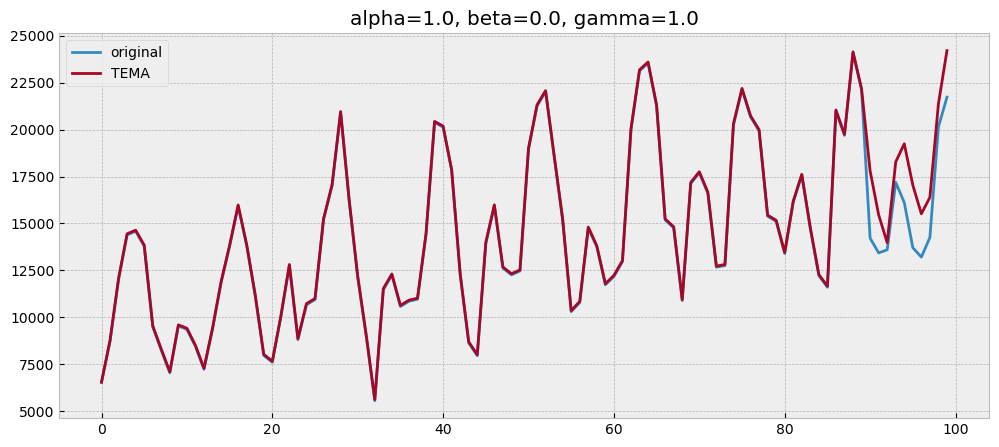

In [19]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:100], n_preds=len(test))

In [20]:
print(f'RMSE={round(mse([alpha_opt, beta_opt, gamma_opt])*0.5, 2)}')

RMSE=2832328.06


### Monthly car sales in quebec, 1960 (stationary)

Аналогично рассмотрим стационарный временной ряд

In [21]:
from scipy.stats import boxcox
import numpy as np

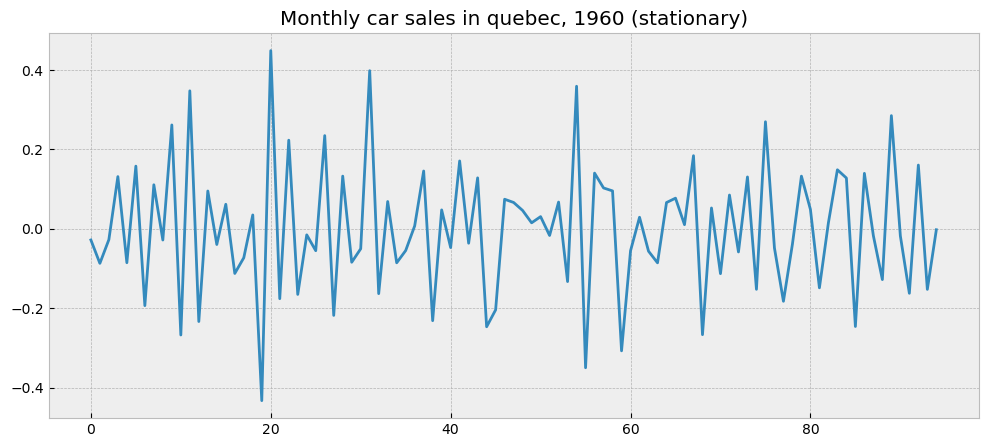

In [22]:
car_sales_stationary = boxcox(car_sales['Count'], 0)   # Нормализуем дисперсию при помощи преобразования Бокса-Кокса
car_sales_stationary = np.diff(car_sales_stationary, 1)   # Уберём тренд из временных рядов при помощи дифференцирования
car_sales_stationary = car_sales_stationary[12:] - car_sales_stationary[:-12]   # Уберём влияние сезонности

plt.figure(figsize=(12, 5))
plt.plot(car_sales_stationary)
plt.title('Monthly car sales in quebec, 1960 (stationary)')
plt.show()

In [23]:
result = adfuller(car_sales_stationary)
print('Dickey-Fuller test for "Monthly car sales in quebec, 1960 (stationary)":')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for k, v in result[4].items():
    print(f'   {k}: {v}')
print()

Dickey-Fuller test for "Monthly car sales in quebec, 1960 (stationary)":
ADF Statistic: -3.5160669545131507
p-value: 0.00758392210534882
Critical Values:
   1%: -3.5117123057187376
   5%: -2.8970475206326833
   10%: -2.5857126912469153



In [24]:
series = car_sales_stationary

In [25]:
train, test, val = series[:90], series[90:100], series[100:]

In [26]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [27]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01868529864876566
        x: [ 3.864e-04  9.309e-01  1.000e+00]
      nit: 35
      jac: [-3.969e-02 -2.750e-05 -2.122e-02]
     nfev: 192
     njev: 48
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


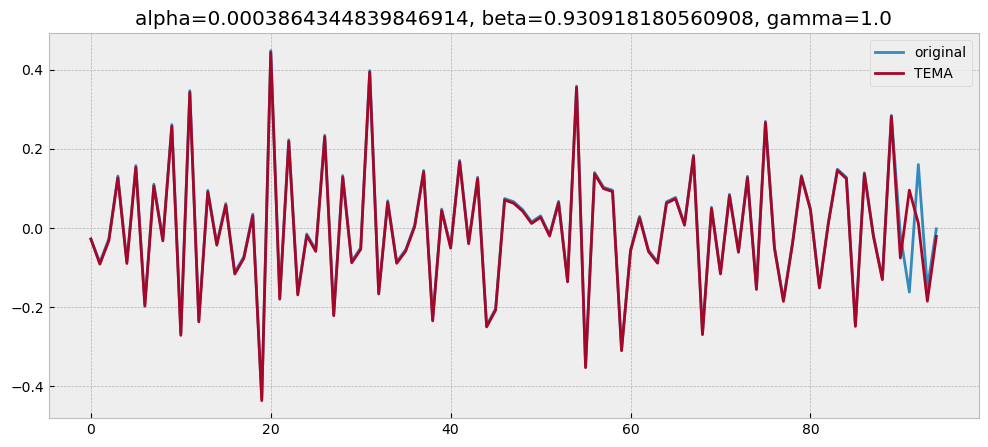

In [28]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:100], n_preds=len(test))

In [29]:
print(f'RMSE={round(mse([alpha_opt, beta_opt, gamma_opt])*0.5, 2)}')

RMSE=0.01
